# Data Science Methods for Clean Energy Research 
## _Decision trees, bagging, random forests and boosting_

## Outline


### 1. Decision trees

* 1.1 Regression trees
* 1.2 Classification trees


### 2. Bagging, Random Forests, Boosting

* 2.1 Bagging
* 2.2 Random Forests
* 2.3 Boosting




---







### Load libraries which will be needed in this Notebook



In [1]:
# Pandas library for the pandas dataframes
import pandas as pd    
import numpy as np

# Import Scikit-Learn library for decision tree models
import sklearn         
from sklearn import linear_model, datasets
from sklearn.utils import resample
from sklearn import tree
from sklearn.tree import DecisionTreeRegressor, DecisionTreeClassifier
from sklearn.ensemble import BaggingClassifier, RandomForestClassifier, GradientBoostingClassifier
from sklearn.model_selection import train_test_split
from sklearn.metrics import r2_score, mean_squared_error, accuracy_score


# Import plotting libraries
import seaborn as sns
import matplotlib 
from matplotlib import pyplot as plt

# Set larger fontsize for all plots
matplotlib.rcParams.update({'font.size': 18})
from IPython.display import clear_output

# Command to automatically reload modules before executing cells
# not needed here but might be if you are writing your own library 
%load_ext autoreload
%autoreload 2


## 1. What are decision tree methods?

Description taken from [wikipedia](https://en.wikipedia.org/wiki/Decision_tree_learning): 

Decision tree learning is one of the predictive modelling approaches used in statistics, data mining and machine learning. It uses a **decision tree** (as a predictive model) to go from **observations** about an item (represented in the **_branches_**) to **conclusions** about the item's target value (represented in the **_leaves_**). 

Tree models where the target variable can take a _discrete set of values_ are called **classification trees**; in these tree structures, leaves represent class labels and branches represent conjunctions of features that lead to those class labels. 

Decision trees where the target variable can take continuous values (typically real numbers) are called **regression trees**. 


We can see the structure and terms to describe a tree below

<div>
<img src="https://wiki.atlan.com/content/images/2019/10/Decision-tree-structure.png" width='350' align=left>
</div>

And an example of classification decision tree 


<div>
<img src="https://d2h0cx97tjks2p.cloudfront.net/blogs/wp-content/uploads/sites/2/2017/07/Decision-Trees-Example.png" width='300' align=left>
</div>

At each node of the tree we are making a decision to ... eventually reach our target, a class or a number.

**Some questions ...**

* How do we build a tree?
* How do we find the best tree?
* Where and when should we create nodes / splits

### 1.1 Regression decision trees

Our aim is to find cutpoints or splits which minize the residual sum of squares RSS

$$\text{RSS} = \sum_{i=1}^{N} \left(y_i - \hat{y}_i\right)^2$$

where $\hat{y}_i$ is the estimated target regression value from the tree.

How can we do that?

**Top-down greedy** a.k.a. **recursive binary splitting** approach:

**Training**

You have some input data $X=\left\{X_1,X_2,...,X_p\right\}$ and a corresponding target $y$
* _**step 1:**_ Divide your input data into a training and testing set
* _**step 2:**_ Pick an input variable or predictor $X_j$ and a cutpoint $s$ which define two groups $R_1(j,s)=\left\{X|X_j<s\right\}$ and $R_2(j,s)=\left\{X|X_j\geq s\right\}$ 
* _**step 3:**_ Repeat for each $j$ and cutpoint $s$ and find the values of $j$ and $s$ which minimize the weigthed average of the MSE's:

$$\sum_{i:x_i\in R_1(j,s)}\left(y_i-\hat{y}^{{\sf ave} }_{R_1}\right)^2 + \sum_{i:x_i\in R_2(j,s)}\left(y_i-\hat{y}^{\sf ave}_{R_2}\right)^2 $$

Here $\hat{y}^{{\sf ave} }_{R_1}$ is the average or mean response for the training set in $R_1$ .. same for the second one which is the mean in $R_2$

**Testing**
* **_step 4_**: Repeat steps 2-3 until you reach a stopping criterion or maximum depth or when you can no longer split (note this last option would result in overfitting). Note that at each iteration we are splitting from previous regions!

Once your tree is built, you will **predict** the numerical response value $y_k^{\sf{test}}$ by using the **mean of the training observations in the region $R_l$ where the test observation is found to belong** based on the tree.


### Regression decision tree using `sklearn`

In [2]:
df = datasets.load_boston()
X, y = datasets.load_boston(return_X_y=True)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.25, random_state=5)

In [3]:
regr = DecisionTreeRegressor()#max_depth=3)
regr.fit(X_train, y_train)


DecisionTreeRegressor()

In [4]:
y_pred = regr.predict(X_test)

In [5]:
print("Prediction accuracy MSE: ", mean_squared_error(y_test, y_pred))

Prediction accuracy MSE:  37.43606299212598


What does our decision tree look like? We will use the `tree.plot_tree` function. A nice blog on plotting decision trees can be found [here](https://mljar.com/blog/visualize-decision-tree/)

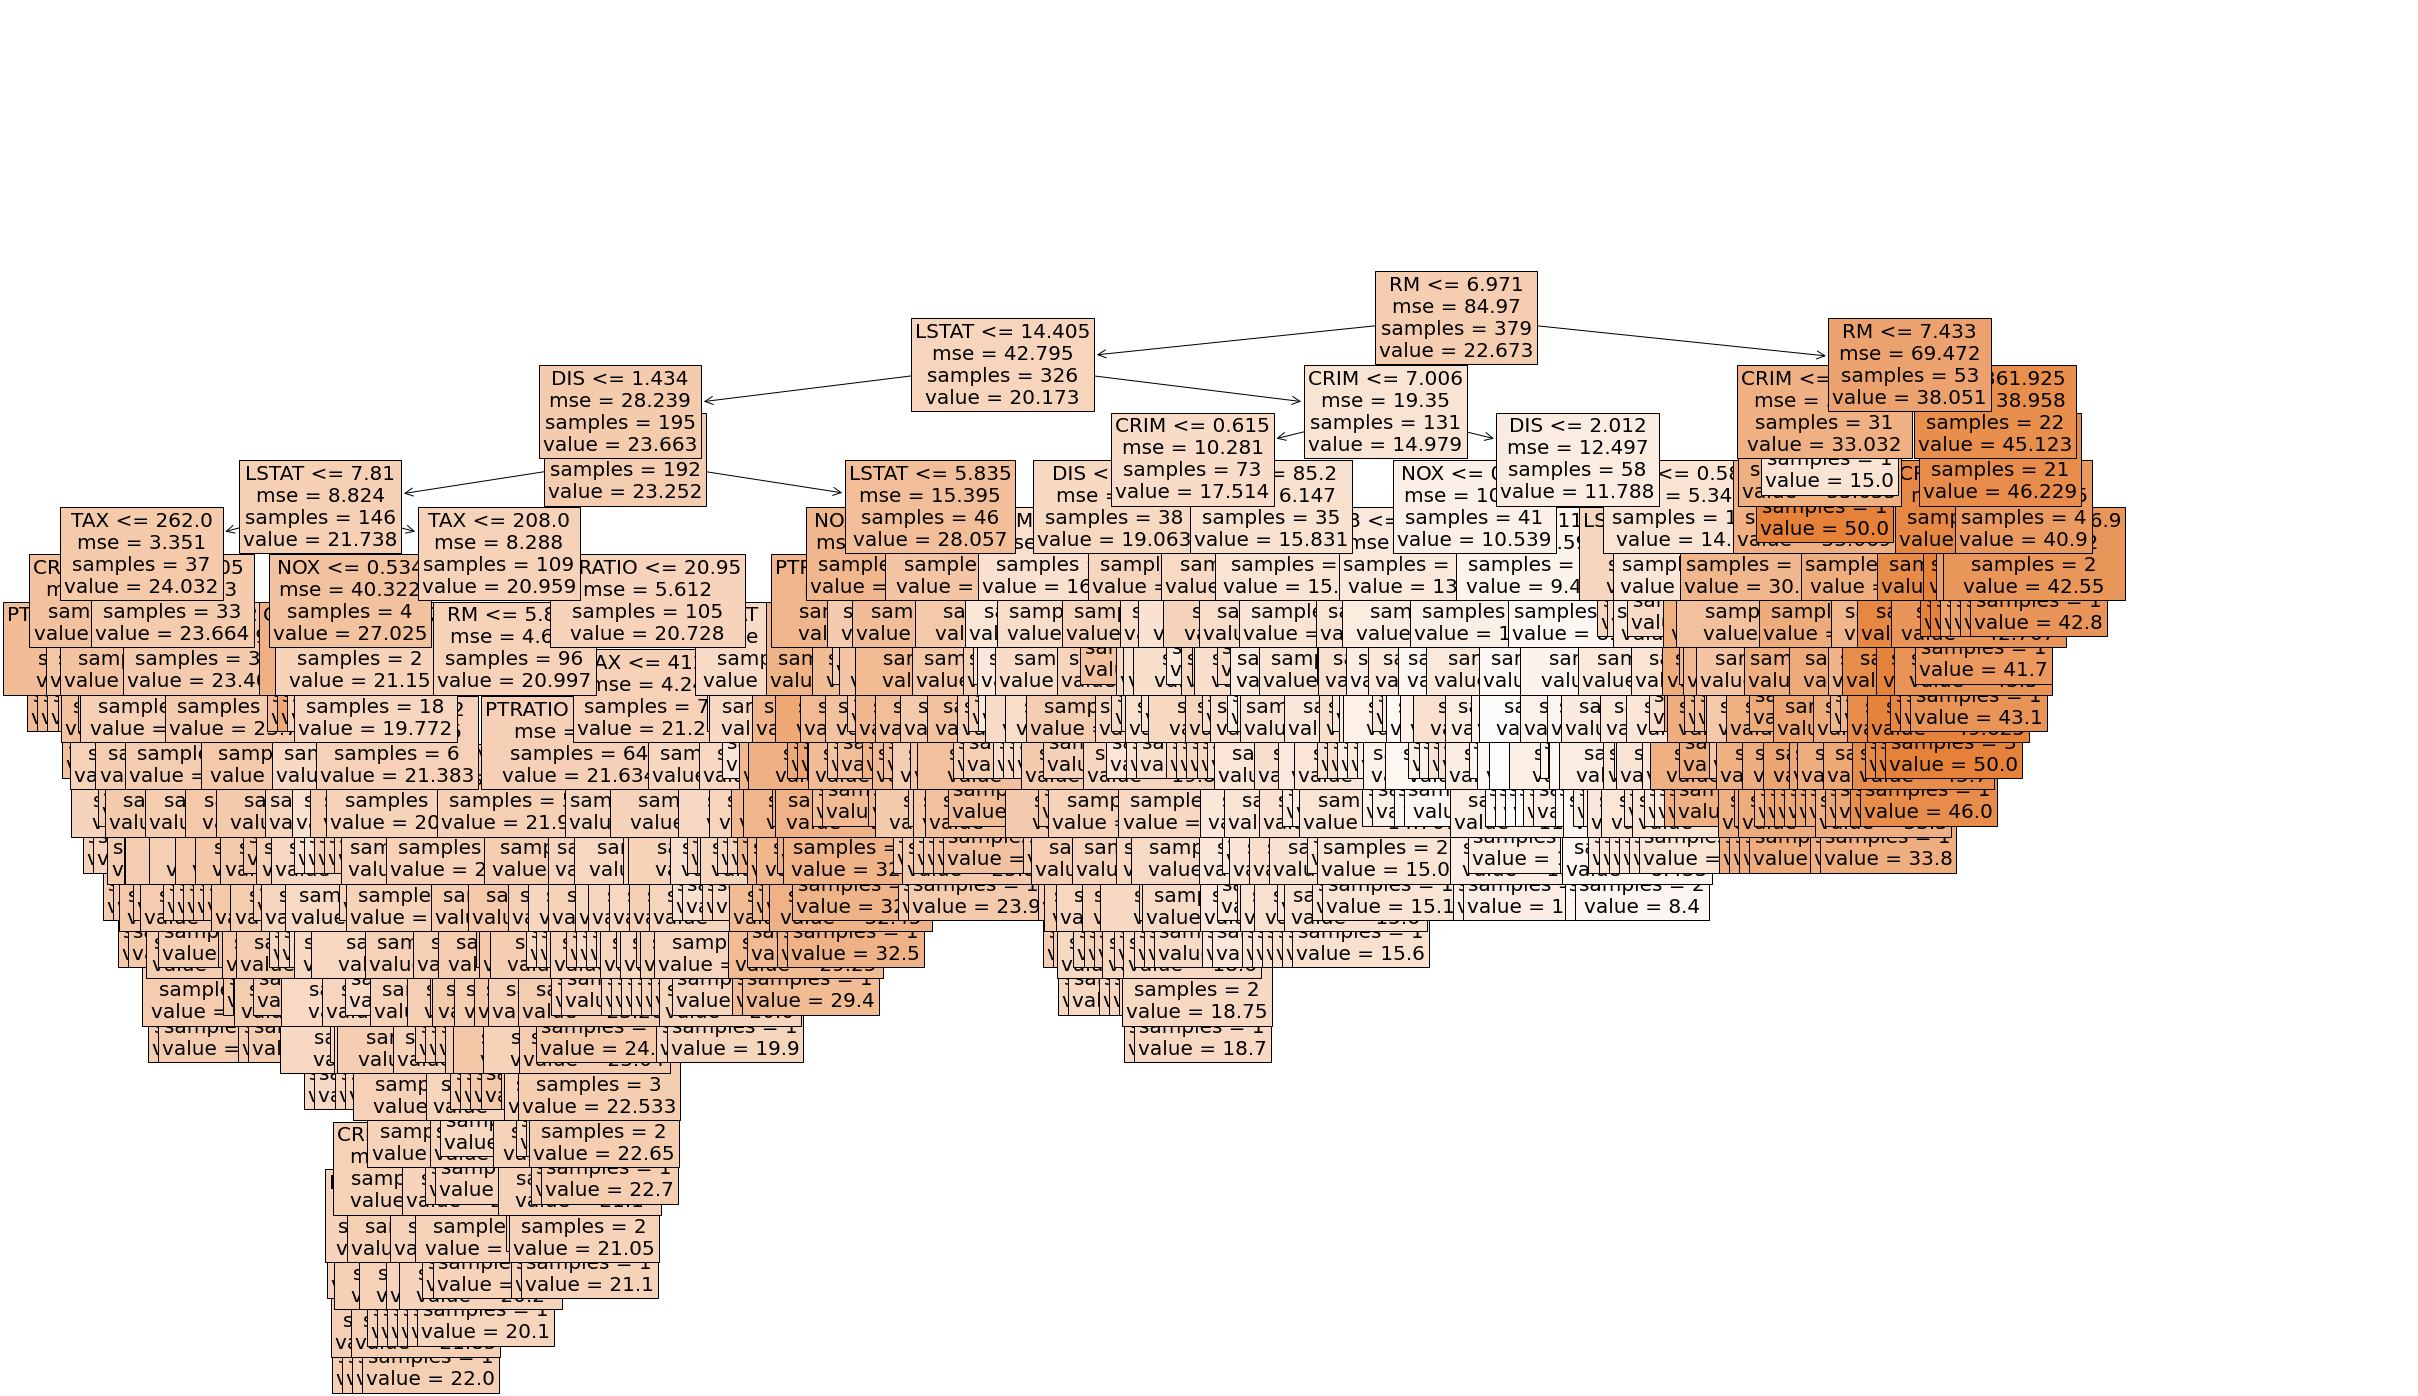

In [6]:
fig = plt.figure(figsize=(35,20))
_ = tree.plot_tree(regr, feature_names=df.feature_names, filled=True, fontsize=20)
plt.tight_layout()

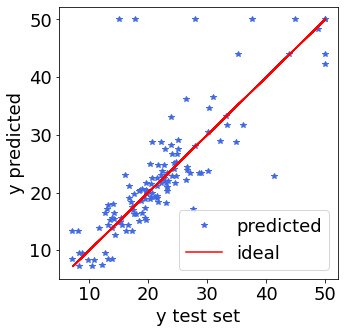

In [7]:
plt.figure(figsize=(5,5))
plt.plot(y_test,y_pred,'*', color='royalblue', label="predicted")
plt.plot(y_pred,y_pred,'-', color='red', label="ideal")
plt.xlabel('y test set')
plt.ylabel('y predicted')
plt.legend()
plt.show()



In [8]:
regr.get_n_leaves()

356

### Exercise (5 min - Breakout room): Play with the `max_depth` parameter

* How does the prediction change with `max_depth`? Try running the above for a set of growing values of `max_depth`

* How does the tree change if you keep `max_depth=5` and change the training dataset (e.g. change the random seed)


What we did effectively can be seen in this picture


<div>
<img src="https://res.cloudinary.com/dyd911kmh/image/upload/f_auto,q_auto:best/v1528907338/regression-tree_g8zxq5.png" width='500' align=left>
</div>

**Problems**

* While predictions on the training set are good, it usually overfits teh data - **high variance**
* We might miss out on the best tree - because we are choosing in order (similarly to forward stepwise selection - multiparameter regression) 
* One solution is **pruning** (for more information see section 8.1 of textbook or [here](https://en.wikipedia.org/wiki/Decision_tree_pruning)). 

### 1.2 Classification decision trees

We can follow an approach which is almost identical to that used for regression decision trees. 

The main difference is that the target is a categorical variable - a class. Also RSS can't be used as an error rate. Instead we have a classification error rate just as in KNN and related methods, e.g. the Gini index or Entropy. For more details see - ISL 8.1.2.


### Summary on decision trees

* Decision trees are easy to explain and interpret
* Decision trees can be displayed graphically
* Can be used both for regression and classification
* Decision trees are not as accurate in terms of level of prediction accuracy respect to other regression and classification approaches
* Decision trees are very sensitive to the data - small changes in the data lead to a large change in the final estimated tree.

## 2. Bagging, Random Forests, Boosting

We can reduce the problem of high variance for Decision Trees by using ensemble methods.

### 2.1 Bagging

Recall that the mean of $N$ observations each with variance $\sigma^2$ is $\frac{\sigma^2}{N}$ - the more we sample, the more accurate our estimated mean. 

Based on this fact in **Bagging** the algorithm is:

* **_Step 1_**: Create $B=\left\{B_1, B_2, ..., B_{N}\right\}$, i.e. $N$ separate training sets using Bootstrapping. Boostrapping saves us the problem of needing $N$ input training sets.
* **_Step 2_**: Train on each $B_k \in B$ to create an estimator $\hat{f}^{\,k}(x)$
    * Consider all input feature pairs.
    * Find the best split point from **all** input features by minimizing the weighted average of the MSE's (or e.g. Gini index if Classifying)
    * Repeat until you reach maximum depth or a stopping criterion
* **_Step 3_**: Average over the estimators to create a single low-variance estimator
$$\hat{f}_{{\sf avg}}(x)=\frac{1}{N}\sum_{k=1}^{N}\hat{f}^{\,k}(x)$$


**Advantage of Bagging**

* While each bootstrap set trained estimator has a high variance and low bias the average over ~ hundreds, thousands largely _reduces the variance_

* Note: Bagging can also be used to reduce the variance of other regression algorithms / can also be used for classification

**Watch out** - with bagging we allow the algorithm to explore all $X$ predictors, this means that most initial splits will include the predictor which is strongest and minimizes the MSE - hence our bagged trees will be similar and **correlated**.


Let's now look at a decision tree for classification. We will load the Iris dataset again.

In [11]:
df_iris = datasets.load_iris()
X, y = datasets.load_iris(return_X_y=True)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.25, random_state=191)

We will use the `BaggingClassifier()` from sklearn - for more info see [here](https://scikit-learn.org/stable/modules/generated/sklearn.ensemble.BaggingClassifier.html#sklearn.ensemble.BaggingClassifier)

In [12]:
estimator = DecisionTreeClassifier(max_depth=10)
clf_bag = BaggingClassifier(base_estimator=estimator, n_estimators=50, random_state=42)

clf_bag = clf_bag.fit(X_train, y_train)


print("Estimator", clf_bag.base_estimator_)
print("Boostrapping with replacement", clf_bag.bootstrap)
print("Names of classes", clf_bag.classes_)
print("Number of classes", clf_bag.n_classes_)


Estimator DecisionTreeClassifier(max_depth=10)
Boostrapping with replacement True
Names of classes [0 1 2]
Number of classes 3


In [13]:
y_BSTR = clf_bag.predict(X_test)

print("Mean accuracy on test set", clf_bag.score(X_test, y_test))
print("Accuracy score", accuracy_score(y_test, y_BSTR))

Mean accuracy on test set 0.9473684210526315
Accuracy score 0.9473684210526315


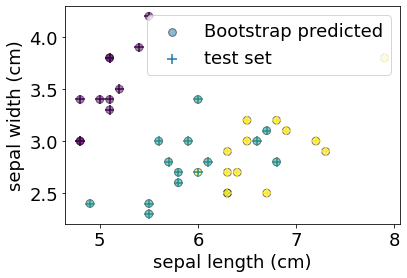

In [14]:
plt.figure()
plt.scatter(X_test[:, 0], X_test[:, 1], marker='o', c=y_BSTR,
            s=60, cmap='viridis', edgecolor='k', alpha = 0.5, label='Bootstrap predicted')
plt.scatter(X_test[:, 0], X_test[:, 1], marker='+', c=y_test,
            s=90, cmap='viridis', edgecolor='k', label='test set')
plt.xlabel(df_iris.feature_names[0])
plt.ylabel(df_iris.feature_names[1])
plt.legend()
plt.show()


### 2.2 Random Forests

The idea of random forests is to **decorrelate** trees by randomly selecting input features as split candidates 

* **_Step 1_**: Create $B=\left\{B_1, B_2, ..., B_N\right\}$, i.e. $N$ separate training sets using Bootstrapping. Boostrapping saves us the problem of needing $N$ input training sets.
* **_Step 2_**: Train on each $B_k \in B$ to create an estimator $\hat{f}^{\,k}(x)$ 
    * **Randomly select $m$ features from total $p$ input features** with  $p<< m$ - usually $m\approx\sqrt p$
    * Find the best split point from the $m$ features by minimizing the weighted average of the MSE's (or e.g. Gini index if Classifying)
    * Repeat for the next split point until you reach maximum depth or a stopping criterion
* **_Step 3_**: Average over the estimators to create a single low-variance estimator
$$\hat{f}_{{\sf avg}}(x)=\frac{1}{N}\sum_{k=1}^{N}\hat{f}^{\,k}(x)$$


### Exercise: Use the Random forest approach on the Iris dataset (10 min)

* Have a look at the sklearn `RandomForestClassifier()` [here](https://scikit-learn.org/stable/modules/generated/sklearn.ensemble.RandomForestClassifier.html)
* See how the test set score changes as you increase the number of trees
* Make sure that you are bootstrapping!
* Plot your predicted classes using a scatter plot for `n_estimators = 50`


In [15]:
clf_RF = RandomForestClassifier(n_estimators=50, random_state=48)
clf_RF = clf_RF.fit(X_train, y_train)


print("Estimator", clf_RF.base_estimator_)
print("Maximum depth", clf_RF.max_depth)
print("Boostrapping with replacement", clf_RF.bootstrap)
print("Names of classes", clf_RF.classes_)
print("Number of classes", clf_RF.n_classes_)

print("Mean accuracy on test set", clf_RF.score(X_test, y_test))

y_RF = clf_RF.predict(X_test)

print("Accuracy score", accuracy_score(y_test, y_RF))

Estimator DecisionTreeClassifier()
Maximum depth None
Boostrapping with replacement True
Names of classes [0 1 2]
Number of classes 3
Mean accuracy on test set 0.9473684210526315
Accuracy score 0.9473684210526315


### 2.3 Boosting

The main idea of Boosting is to learn from the data slowly by fitting a decision tree to the **residuals** of the model rather than to the target output Y.

Boosting works **sequentially** - each tree is grown from previously trained trees. Boosting does not use bootstrapping. 

**Algorithm for Boosting**

* **_Step 1_**: Define an initial estimator function $\hat{f}(x)=0$ and residuals $r_i=y_i$ for all data points $i$ in the training set
* **_Step 2_**: Select a number of trees $N$, and for each iteration in $B$, $b=1,2,...,N$
    * Fit a tree $\hat{f}^{\,b}$ with a _chosen number of splits $d$_ to the training data (we will have $d+1$ terminal nodes)
    * Update the overall estimator $\hat{f}(x)$ as
    $$\hat{f}(x)\leftarrow \hat{f}(x)+\lambda\hat{f}^{\,b}(x)$$ 
    where $\lambda$ is a _shrinkage parameter_ usually $\approx$ 0.01 or 0.001
    * Update the residuals
    $$r_i\leftarrow r_i-\lambda\hat{f}^{\,b}(x)$$
* **_Step 3_**: The boosted model is obtained as
$$\hat{f}(x)=\sum_{b=1}^{N}\lambda\hat{f}^{\,b}(x) $$

Some disadvantages of Boosting models:

* Boosting models are more sensitive to overfitting if the data is noisy.
* It takes longer to train Boosting models given that trees are built sequentially.
* More difficult to fit than Random Forests because we have three parameters - number of trees $N$, shrinkage parameters $\lambda$ and $d$ number of splits per tree.

Here we can use the `sklearn` gradient boosting classifier function - documentation can be found [here](https://scikit-learn.org/stable/modules/generated/sklearn.ensemble.GradientBoostingClassifier.html#sklearn.ensemble.GradientBoostingClassifier)

In [16]:
clf_GBM = GradientBoostingClassifier(n_estimators=1000, max_depth=10, learning_rate=0.1, random_state=42)
clf_GBM = clf_GBM.fit(X_train, y_train)


print("Maximum depth", clf_GBM.max_depth)
print("Names of classes", clf_GBM.classes_)
print("Number of classes", clf_GBM.n_classes_)

print("Mean accuracy on test set", clf_GBM.score(X_test, y_test))

y_GBM = clf_GBM.predict(X_test)

print("Accuracy score", accuracy_score(y_test, y_GBM))

Maximum depth 10
Names of classes [0 1 2]
Number of classes 3
Mean accuracy on test set 0.9473684210526315
Accuracy score 0.9473684210526315


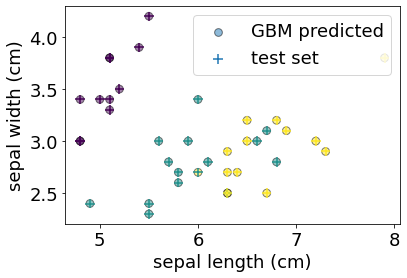

In [17]:
plt.figure()
plt.scatter(X_test[:, 0], X_test[:, 1], marker='o', c=y_GBM,
            s=60, cmap='viridis', edgecolor='k', alpha = 0.5, label='GBM predicted')
plt.scatter(X_test[:, 0], X_test[:, 1], marker='+', c=y_test,
            s=90, cmap='viridis', edgecolor='k', label='test set')
plt.xlabel(df_iris.feature_names[0])
plt.ylabel(df_iris.feature_names[1])
plt.legend()
plt.show()

That's all for today! In your homework you will get to look at using some of these methods for regression.

## In class exercise (10 min breakout rooms) ... what is the maximum number of leaves?

When you get back in the main room select one person from your breakout room to give an answer in the chat :)

Use the boston dataset as loaded below and see what the maximum depth of the tree is. 
Use the `DecisionTreeRegressor()` function and fit it to the training data ... what is the value of the maximum number of leaves?

In [24]:
df = datasets.load_boston()
X, y = datasets.load_boston(return_X_y=True)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.25, random_state=5)

In [29]:
print(X_train.shape)

(379, 13)


In [31]:
Npoints = 15
regr = DecisionTreeRegressor()#max_depth=3)
regr.fit(X_train[0:Npoints], y_train[0:Npoints])
print(regr.max_depth)
print("depth", regr.get_depth())
print("number of leaves", regr.get_n_leaves())

None
depth 6
number of leaves 14


Use the Iris dataset as loaded below and see what the maximum depth of the tree is. 
Use the `DecisionTreeClassifier()` function and fit it to the training data ... what is the value of the what is the value of the maximum number of leaves?

In [47]:
df_iris = datasets.load_iris()
X, y = datasets.load_iris(return_X_y=True)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.25, random_state=191)

In [48]:
print(X_train.shape)

(112, 4)


In [74]:
Npoints = 112
clf = DecisionTreeClassifier(max_depth=2)
clf.fit(X_train, y_train)
print(clf.max_depth)
print("depth", clf.get_depth())
print("number of leaves", clf.get_n_leaves())
print("number of classes", clf.n_classes_)

2
depth 2
number of leaves 3
number of classes 3


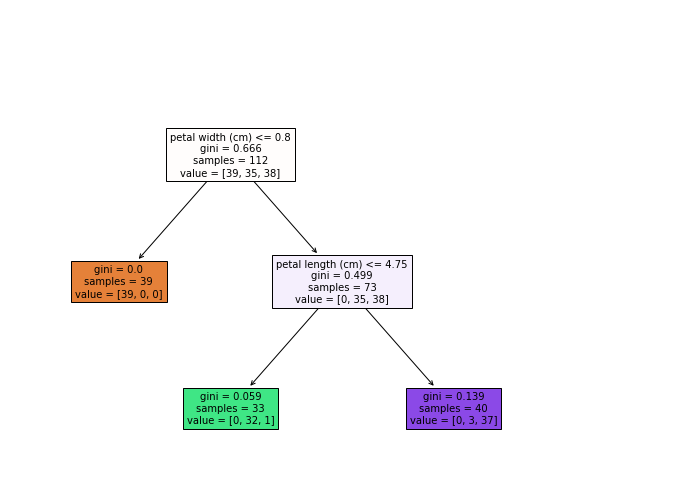

In [75]:
fig = plt.figure(figsize=(10,7))
_ = tree.plot_tree(clf, feature_names=df_iris.feature_names, filled=True, fontsize=10)
plt.tight_layout()